#Hello, simulated world!

Simulation of a simple scenario to demonstrate how to structure a custom simulation project, based on a model of [lean simulator development](https://safetydave.net/leave-product-development-to-the-dummies-agile-australia/). We cover the following stages:

1. Study of the real world
2. Core algorithms
3. Translation of performance and design
4. Experimentation
5. Translation of an environment
6. Experimentation in noisy environments 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

ANNUAL_FORTNIGHTS = 26

## Study of the real world

### A bank account

To keep the core algorithms really simple - as befits a `Hello, World!` example - we will study how a bank account works. In our study, we recognise the essential features of a balance, deposits and withdrawals. The balance is increased by deposits and reduced by withdrawals.

In [2]:
class Account:

  def __init__(self):
    self.balance = 0

  def deposit(self, amount):
    self.balance = self.balance + amount

  def withdraw(self, amount):
    self.balance = self.balance - amount

We can test that the balance behaves as expected in simple scenarios. These are examples of [point tests](https://www.thoughtworks.com/en-au/insights/blog/testing/practical-data-test-grid).

In [3]:
def test_BalanceShouldEqualFirstDeposit():
  account = Account()
  amount = 10
  account.deposit(amount)
  return account.balance == amount

In [4]:
def test_BalanceShouldReflectTransactions():
  account = Account()
  d1, d2, w1 = 10, 20, 5
  expected_balance = d1 + d2 - w1
  account.deposit(d1)
  account.deposit(d2)
  account.withdraw(w1)
  return account.balance == expected_balance  

In [5]:
test_BalanceShouldEqualFirstDeposit()

True

In [6]:
test_BalanceShouldReflectTransactions()

True

## Core algorithms

Core algorithms reproduce real world phenomena, in some domain, be it phyiscal processes, behaviour of agents, behaviours of systems, etc

### A simulated bank account

We can simulate how our simple model of bank account will behave when we perform some set of transactions on it. In the realm of simulation, these are possible rather than actual transactions.

In [7]:
def simulate_transaction(account, kind, amount):
  if kind == 'd':
    account.deposit(amount)
  elif kind == 'w':
    account.withdraw(amount)
  else:
    raise ValueError("kind must be 'd' or 'w'")

def simulate_balance(transactions):
  account = Account()
  balances = [account.balance]
  for t in transactions:
    simulate_transaction(account, t[0], t[1])
    balances.append(account.balance)
  return balances

When we simulate the bank account, note that we are interested in caputing a fine-grained view of its behaviour and how it evolves (the sequence of balances), rather than just the final state. The final state can be extracted in the "translation" layer if required.

In [8]:
tx = [('d', 10), ('d', 20), ('w', 5)]
sb = simulate_balance(tx)
sb

[0, 10, 30, 25]

Visualisation is critical in simulator development - it helps to communicate function, understand results, validate and tune implementation and diagnose errors, at every stage of development and operation of a simulator.

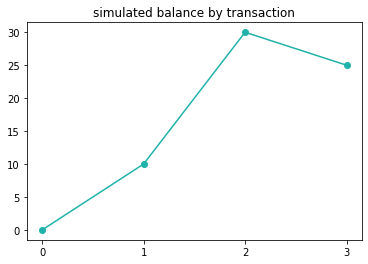

In [9]:
def visualise_balance(simulated_balance):
  plt.plot(simulated_balance, '-o', c='lightseagreen')
  plt.xticks(list(range(len(simulated_balance))))
  plt.title('simulated balance by transaction')

visualise_balance(sb)
plt.show()

## Translation of performance and design

A translation layer is where we add human intent and judgement to what was previously just a simplified [best attempt] objective reproduction of real observable phenomena. The translation layer allows people to specify high-level performance measures used to evaluate high-level system designs, while machines  simulate all the rich detail of a virtual world using the core algorithms.

### Performance

We decide for our `Hello, World!` example that this is a transactional account, and we care about keeping the balance close to a target balance, so that sufficient funds will be available but we don't leave too much money in a low interest account. We therefore measure performance as the average (mean) absolute difference between the balance at each transaction, and the target balance. This may be imperfect, but there are often trade-offs, so consider different performance measures in that case.

In [10]:
def translate_performance_TargetBalance(balances, target):
  return sum([abs(b - target) for b in balances]) / len(balances)

### Design

While we can make any arbitrary number of transactions and decide about each individual transaction, we consider that we can set up a fortnightly deposit schedule, and make one decision about the amount of that fortnightly deposit.

We can translate this single design parameter into a list of every individual transaction, suitable for simulation by core algorithms.

In [11]:
def translate_design_FortnightlyDeposit(fortnightly_deposit):
  return [('d', fortnightly_deposit)] * ANNUAL_FORTNIGHTS

In [12]:
translate_design_FortnightlyDeposit(10)[:5]

[('d', 10), ('d', 10), ('d', 10), ('d', 10), ('d', 10)]

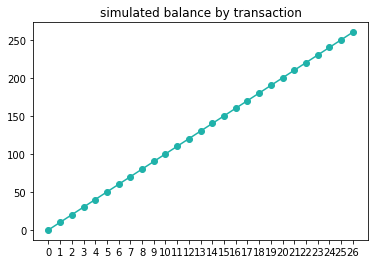

In [13]:
visualise_balance(simulate_balance(translate_design_FortnightlyDeposit(10)))
plt.show()

### Performance = f(Design)

Now we can chain together human-relevant design -> design translation -> core algorithm simulation -> performance translation -> human-relevant performance measure.

In [14]:
def performance_of_design(performance_parameter, design_parameter):
  return translate_performance_TargetBalance(
      simulate_balance(translate_design_FortnightlyDeposit(design_parameter)),
      performance_parameter)

We can evaluate the performance for a particular design

In [15]:
des_par = 5
perf_tgt = 100

print(f'evaluating account balance target {perf_tgt} with fortnightly deposit {des_par}')
print(f'the mean abs delta is {performance_of_design(100, 5):.2f}')

evaluating account balance target 100 with fortnightly deposit 5
the mean abs delta is 42.78


And we can produce visualisations of the simulated systems to illustrate that performance measure

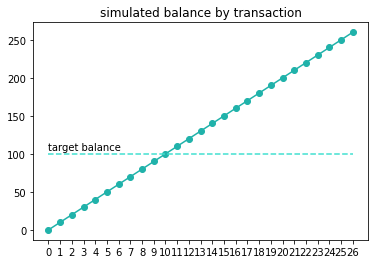

In [16]:
visualise_balance(simulate_balance(translate_design_FortnightlyDeposit(10)))
plt.plot([0, ANNUAL_FORTNIGHTS], [perf_tgt, perf_tgt], '--', color='turquoise')
plt.text(0, perf_tgt + 5, 'target balance')
plt.show()

### Alternative design

After visualising the result of our design against our performance measurem, an alternative design suggests itself. Instead of having just a fixed fortnightly deposit, we could make an initial large deposit, followed by smaller fortnightly deposits. 

In [17]:
def translate_design_InitialAndFortnightlyDeposit(initial_deposit, fortnightly_deposit):
  return [('d', initial_deposit)] + [('d', fortnightly_deposit)] * ANNUAL_FORTNIGHTS

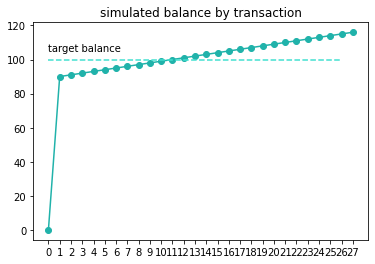

In [18]:
des_par_1 = 90
des_par_2 = 1

visualise_balance(
    simulate_balance(
        translate_design_InitialAndFortnightlyDeposit(des_par_1, des_par_2)))
plt.plot([0, ANNUAL_FORTNIGHTS], [perf_tgt, perf_tgt], '--', color='turquoise')
plt.text(0, perf_tgt + 5, 'target balance')
plt.show()

# Experimentation

Explore simulated results through the simple interface of `performance = function(design)`. Note that while `performance` and `design` are both single values (scalars) in our `Hello, World!` example, in general they would both consist of multiple, even hundreds of, parameters.

### Exploration

Vary design parameters and observe the effect on performance. This can be through regular sweeps or grid searches, interactive exploration, or other methods. Visualisation is again key to understand, calibrate and validate simulated behaviour.

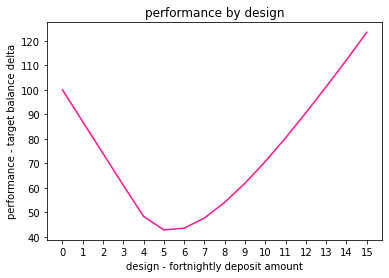

In [19]:
def performance_of_design_variants(target_balance, design_variants):
  return [performance_of_design(target_balance, d) for d in design_variants]

def visualise_performance_of_designs(performances, designs):
  plt.plot(designs, performances, color='deeppink')
  plt.xticks(designs)
  plt.xlabel('design - fortnightly deposit amount')
  plt.ylabel('performance - target balance delta')
  plt.title('performance by design')

design_sweep = list(range(16))
performances = performance_of_design_variants(100, design_sweep)
visualise_performance_of_designs(performances, design_sweep)
plt.show()

### Optimisation

Automate the exploration of the design space by machines to find the designs that produce optimal performance. `scipy.optimize.minimize()` is a simple method to optimise a function.

In [20]:
minimum_design = minimize(lambda x: performance_of_design(perf_tgt, x), [3]).x

We can visualise the optimal design in the context of our previous parameter sweep.

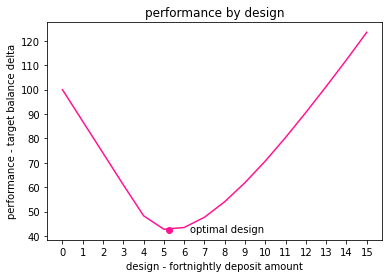

In [21]:
visualise_performance_of_designs(performances, design_sweep)
plt.scatter([minimum_design], [performance_of_design(100, minimum_design)], color='deeppink')
plt.text(minimum_design + 1, performance_of_design(100, minimum_design) - 1, 'optimal design')
plt.show()

## Include environment

The example so far assumes we have complete control of the inputs to the system. This is rarely the case in the real world. This section introduces environmental factors that we track - but consider out of our control - into the simulation.

### Translation layer

Environmental factors identified by humans need to be translated for simulation by core algorithms. In this case, we have a random fortnightly expense that represents a withdrawal from the account.

In [22]:
def translate_environment_FortnightlyRandomWithdrawal(seed=42, high=5):
  rng = np.random.RandomState(seed)
  random_withdrawals = rng.randint(0, high=high, size=ANNUAL_FORTNIGHTS)
  return list(zip(['w'] * ANNUAL_FORTNIGHTS, random_withdrawals))

translate_environment_FortnightlyRandomWithdrawal()[:5]

[('w', 3), ('w', 4), ('w', 2), ('w', 4), ('w', 4)]

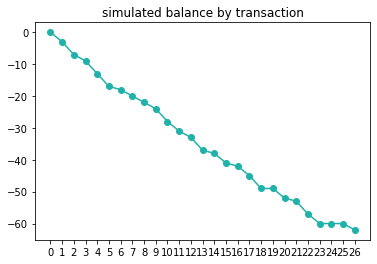

In [23]:
visualise_balance(simulate_balance(translate_environment_FortnightlyRandomWithdrawal()))
plt.show()

Now we translate design decisions and environmental factors together into the inputs for the simulation core algorithms

In [24]:
def translate_design_and_environment(design_parameter):
  interleaved = zip(translate_environment_FortnightlyRandomWithdrawal(),
                    translate_design_FortnightlyDeposit(design_parameter))
  return [val for pair in interleaved for val in pair]

translate_design_and_environment(10)[:10]

[('w', 3),
 ('d', 10),
 ('w', 4),
 ('d', 10),
 ('w', 2),
 ('d', 10),
 ('w', 4),
 ('d', 10),
 ('w', 4),
 ('d', 10)]

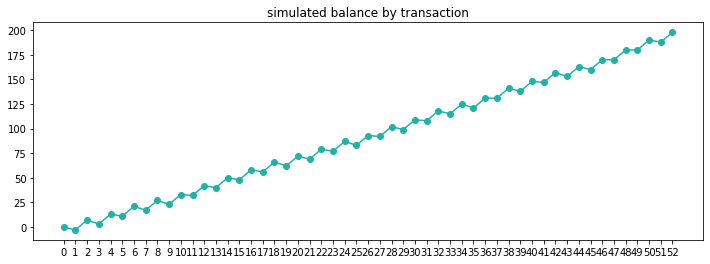

In [25]:
plt.figure(figsize=(12, 4))
visualise_balance(simulate_balance(translate_design_and_environment(10)))
plt.show()

And with this translation, we can evaluate the performance of a design in a given environment. Note that the performance measure is different and worse to the previous evaluation in an environment with no withdrawals.

In [26]:
def performance_of_design_in_environment(performance_parameter, design_parameter):
  return translate_performance_TargetBalance(
      simulate_balance(translate_design_and_environment(design_parameter)),
      performance_parameter)

performance_of_design_in_environment(perf_tgt, des_par)

print(f'evaluating account balance target {perf_tgt} with fortnightly deposit {des_par} with random withdrawal environment')
print(f'the mean abs delta is {performance_of_design_in_environment(perf_tgt, des_par):.2f}')

evaluating account balance target 100 with fortnightly deposit 5 with random withdrawal environment
the mean abs delta is 71.32


## Experimentation in noisy environments

The environment we created is noisy - it has non-deterministic values. To properly evaluate a design in this environment, we would need to run multiple trials. I plan to add an example of this, but it's left as an exercise to the reader for now.

## Conclusion

Final thought. Simulation scenarios become arbitrarily complex. We first validate the behaviour in the simplest point scenarios that have analytic solutions, as above. We can then calibrate against more complex real world scenarios, but when we are sufficiently confident the core algorithms are correct, we accept that the simulation produces the most definitive result for the most complex or novel scenarios. Most of the work is then in translating human judgements about design choices and relevant performance measures into a form suitable for exploration and simulation.